# TMA4320 Biophysics project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

Polymers are the building blocks of DNA, RNA and proteins. Polymers themselves consist of repeating units called monomers. In this project, polymers will be represented numerically in order to make energy calculations as the polymers rotate around their monomers. FORTSETTELSE INNTRODUKSJON.

(Kommentere på at følgende setning svarer på 1a?) A polymer with $N$ monomers will be represented by a $N\times 2$-array containing the $N$ sets of $x$- and $y$-coordinates of their monomers. The polymer is visualized in an $N\times N$-grid with the origin placed in the bottom left corner.

The following function $\texttt{createPolymer}$, as described in task 1b), recieves the argument $N$ and returns a polymer of size $N$ shaped as a horizontal line. To determine the $y$-coordinate, integer division is used. 

In [14]:
# First, we import necessary libaries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import timeit

In [15]:
def createPolymer(N):
    polymer = np.zeros((N, 2))                             # initialize an Nx2-array to represent the polymer
    polymer[:, 1] = N // 2                                 # place same y-coordinate for all monomers
    polymer[:, 0] = np.array([x for x in range(N)])        # place x-coordinat
    return polymer                                         # returns polymer shaped as a horizontal line

To answer task **1c)** In order to follow the rules that determines valid polymers, the energy will remain unchanged after a rotation around an endpoint. The energy of a polymer is determined by distance between its monomers. When a polymers is rotated around an endpoint, its monomers does not recieve any new neighbours and as a result the energy of the polymer does not change. Rotating around the endpoints is also a seemingly "pointless" rotation, since it doesn't change the structure of the polymer, it just changes the direction of which the polymer lies in our 2D grid.

In algorithm 1 and 2 from the project description, we are to choose a random monomer to rotate around. To decrease the run time of the code, we've decided not to include the edge monomers, since this does not change the configuration of the polymer. As explained in the latter paragraph, the physical interpretation of rotating around the endpoints, as far as we know, is just changing the direction of which the polymer lies in our grid, nothing more. Therefore we argue that excluding rotation around endpoints wouldn't just improve the time of our code, but that it would also give a better understanding of polymer behavior.

The two ways, to include rotation around endpoints or to exclude it, does result in slighty different statistics, for example percentage of legal rotations or the time it takes for an energy jump. For polymers of many monomers, this difference in statistics is negligible, but for polymers of few monomers (eg. under 10), this difference is significant. Since we have decided to exclude rotation around endpoints, we believe it is important to be aware of this statistical difference.

The following code implements a function that visualizes the polymer, as asked for in task **1d)**. The polymer is shown in the yellow/green squares. In the $(N+1)\times (N+1)$-grid the polymer is situated, we change the background value to $-N/2$, a value not too high, and not too low, to better extinguish our polymer from the background, but also to still be able to uniquely identify monomers. Monomers with small indices are represented by darker colours, while monomers with greater indices are represented by brighter colours. We illustrate it in a $(N+1)\times (N+1)$-grid, because *denne grunnen*. 

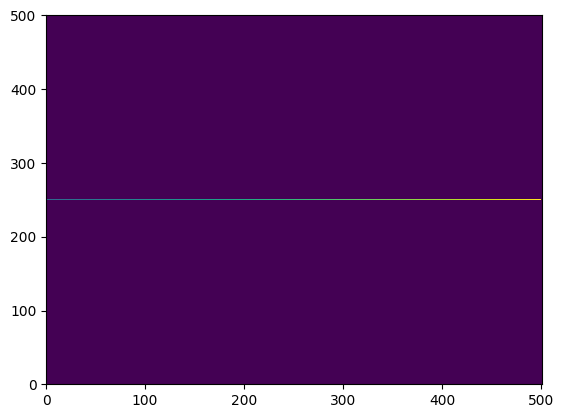

In [16]:
def illustratePolymer(polymer):
    N = len(polymer)                               # calculate the size of the input polymer
    grid = np.zeros((N + 1, N + 1))                # initialize an (N+1) * (N+1) grid
    grid -= N//2                               # set background value to -N / 2 for a better visualization of monomers with small indices

    for monomerNumber in range(N):                 # loop through all monomers of the input polymer
        x = int(polymer[monomerNumber, 0])         # collect x-coordinate of the monomer
        y = int(polymer[monomerNumber, 1])         # collect y-coordinate of the monomer
        grid[y, x] = monomerNumber + 1             # set the value of the point (x, y) in the grid to the index of the monomer + 1 (i.e. start at 1)

    plt.pcolormesh(grid)
    plt.show()

illustratePolymer(createPolymer(500))

While rotating a polymer around its monomers, one easily ends up with a polymer that does not meet the requirements as listed in task **1e)**. The following function receives a polymer and its size $N$, and checks whether it is valid or not. The function $\texttt{validPolymer}$ returns $\texttt{True}$ if the polymer is valid, and $\texttt{False}$ otherwise. To make sure that no monomers have the same coordinates, we initialize the set $\texttt{coordinateSet}$, where we add the monomer-coordinates as we loop through the monomers of the polymer. Once a monomer with already taken coordinates is encountered, $\texttt{validPolymer}$ returns $\texttt{False}$. If a monomer has unique coordinates $(x, y)$, the tuple $(x, y)$ is added to $\texttt{coordinateSet}$.

In [17]:
@jit
def validPolymer(polymer, N):
    if len(polymer) != N:                                      # check if the length of the polymer does not match the input length
        return False
    
    coordinateSet = set()                                      # initialize empty set
    coordinateSet.add((polymer[0, 0], polymer[0, 1]))          # add x- and y-coordinate of the first monomer

    for monomerNumber in range(1, N):                          # loop through the remaining monomers of the polymer

        if (polymer[monomerNumber, 0], polymer[monomerNumber, 1]) in coordinateSet: # check if the monomers coordinates are taken by a preceding monomer
            return False                                                            
        else: 
            coordinateSet.add((polymer[monomerNumber, 0], polymer[monomerNumber, 1])) # if the coordinates are unique, add them to coordinateSet

        xDiff = np.abs(polymer[monomerNumber, 0] - polymer[monomerNumber - 1, 0])     # x-distance to the preceding monomer
        yDiff = np.abs(polymer[monomerNumber, 1] - polymer[monomerNumber - 1, 1])     # y-distance to the preceding monomer
        if xDiff + yDiff != 1:    # if the sum of the x- and y-distance to the preceding monomer is not 1, the preceding monomer is not its neighbour
            return False          
        
    return True    

Next code block implements the function described in task **1f)**. The function $\texttt{rotatePolymer}$ receives an input polymer and a monomer which the polymer will rotate around. $\texttt{rotatePolymer}$ also receives a boolean $\texttt{positiveDirection}$. $\texttt{positiveDirection=True}$ rotates the polymer in the positive direction, while $\texttt{positiveDirection=False}$ rotates the polymer in the negative direction. 

The placement of each monomer in the polymer after a rotation around a monomer $m_{rot}$, is determined by it's relative distance in $x$-direction $\Delta x$ to $m_{rot}$ and it's relative distance in $y$-direction $\Delta y$ to $m_{rot}$. We look at the monomers positions relative to $m_{rot}$ as free vectors, and since we will either be rotating them in positive or negative direction, we can simply multiply by the rotation matrix, either positive direction, or negative direction.

In positive rotation, the original vector $(1,0)$ will go to $(0,1)$ and the vector $(0,1)$ will go to $(-1,0)$. In negative rotation, the original vector $(1,0)$ will go to $(0,-1)$ and $(0,1)$ will go to $(1,0)$ in negative rotation. This is essentially all the information we need to implement rotation, since rotation is a linear operation, and these two vectors forms an orthonormal basis for $\mathbb{R}^2$.


In [18]:
@jit
def rotatePolymer(polymer, monomer, positiveDirection):
    monomer -= 1                                            # subtract 1 from the monomerNumber, as the polymer-array is zero-indexed
    middleMonomer = len(polymer) // 2                       # find monomerNumber of the middle monomer in the polymer
    x, y = polymer[monomer]                                 # collect x- and y-coordinates of the monomer the polymer will rotate around
    newPolymer = np.zeros((len(polymer),2))                 # initialize a new polymer, because working inplace changed *noe*

    if middleMonomer > monomer:
        newPolymer[monomer:] = polymer[monomer:]
        newPolymer[:monomer, 0] = (2 * positiveDirection - 1) * (polymer[:monomer, 1] - y) + x
        newPolymer[:monomer, 1] = (1 - 2 * positiveDirection) * (polymer[:monomer, 0] - x) + y
        """
        Positive direction:
        delta x = delta y
        delta y = - delta x
        Negative direction:
        delta x = - delta y
        delta y = delta x

        Also uses that True is represented as 1 and False as 0.
        """
        return newPolymer
    newPolymer[:monomer+1] = polymer[:monomer+1]
    newPolymer[monomer+1:,0] = (1-2*positiveDirection)*(polymer[monomer+1:,1]-y)+x
    newPolymer[monomer+1:,1] = (2*positiveDirection-1)*(polymer[monomer+1:,0]-x)+y
    """
        Positive direction:
        delta y = delta x
        delta x = - delta y
        Negative direction:
        delta y = - delta x
        delta x = delta y
    """
    return newPolymer

## g)
Her roterer vi masse

In [19]:
def rotateNTimes(N, Ns):
    rotationsMade = 0
    polymer = createPolymer(N)

    for i in range(Ns):
        monomer = np.random.randint(2, N)
        positivRetning = np.random.choice([True, False])

        twistedPolymer = rotatePolymer(polymer, monomer, positivRetning)
        if validPolymer(twistedPolymer, N):
            rotationsMade += 1
            polymer = twistedPolymer

    return polymer, rotationsMade

# h)
One of the main problems within the computation time as of now is the time it takes to rotate the polymer. With the implementation we have used up to now, we split the cases so that we always only rotate the shorter side of the polymer. Thus on average, the length of the chain we rotate will be N/2*½ = N/4. As we change both the x and the y value for each of these every time, we alter N/2 numbers on average each time. To lower this number, we reimplement the structure of the polymere. Instead of having an $N\times 2$ array which tracks the polymers coordinates, we use the fact that the polymer must be connected. 

Thus, we create our own object called Middle, which tracks the x and y coordinates of the middle and also contains two arrays. The first, called beforeMiddle, is of length number of monomers left of the middle, and it contains a singular element in each slot, namely the direction the next monomer is, relative to where one came from. 0 means straight forward, 1 means to the right and 3 means to the left. Similarly, afterMiddle does the same for the right side, just that 2 means straight forward, 1 means to the left and 3 means to the right. Finally, we have also assigned Middle with a map, just to easily keep the data together, the map maps from direction number to correct movement in the cartesian plane. 

This new implementation speeds up the rotation algorithm, as instead of changing on average N/2 datapoints, we only need to rotate one “pointer”, as then the relative distance for all points more extreme will also be moved. Furthermore, this also keeps the invaluable property that the middle always is in the center, as all pointers point from the center to the extremes. This was made possible by changing the polymer in-place, and thus avoiding copying the entire array. To change the polymer in-place was made possible by implementing an else in the rotateManyTimes. If the new polymer wasn’t legal, one would just rotate the polymer on the same monomer in the other direction. To do things like illustrate the polymer, we just start from the middle and illustrate each end by keeping track of the position we are at, which way we look and which way the pointer wants us to move. Thus, we can always construct the appropriate x and y coordinates in linear time, which is more than fast enough as all algorithms that need the x and y coordinates use linear time regardless, and results tell us that the algorithms that take linear time like for instance to check if a polymer is valid, often operate faster with the new implementation. As can be observed in the following code, this new implementation almost halves the computational time of rotateManyTimes.


In [20]:
class Middle:
    def __init__(self, x, y, N):
        self.position = np.array([x,y]) #Position of the middle
        self.beforeMiddle = np.array([0 for i in range(N//2)]) #Venstre siden av arrayet
        self.afterMiddle = np.array([2 for i in range((N-1)//2)]) # Høyre siden av arrayet
        self.map = {0:np.array([0,-1]), 1:np.array([1,0]), 2:np.array([0,1]),3:np.array([-1,0])} # Map of direction to Cartesian-coordinates change

"""
1 b) This is a new createPolymer designed around the new implementation of a polymer
"""
def createPolymerVer2(N):
    middle = Middle(N//2, N//2, N)    # Initializes the class
    return middle
"""
1 d) This is a new way to illustrate the polymer using the same principles as above but with the new implementation in mind
"""
def illustrationPolymerVer2(polymer):
    N = len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1        
    grid = np.zeros((N+1,N+1))        # Creates (N+1)*(N+1) grid
    grid -= N//2                         # Sets the backgroundvalue to -N/2 rounded down
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    for firstMonomers in range(index-1,-1,-1):
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = firstMonomers + 1
    direction = 2
    position = np.copy(polymer.position)
    grid[position[0],position[1]] = index + 1
    for secondMonomers in range(0, len(polymer.afterMiddle)):
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        grid[position[0],position[1]] = secondMonomers+ index + 2
    plt.pcolormesh(grid)
    plt.show()

"""
1 e) Checks if the polymer is intact and legal
"""

def validPolymerVer2(polymer, N):
    if len(polymer.beforeMiddle) + len(polymer.afterMiddle) + 1 != N: #Is the polymer of correct length
        return False
    coordinateSet = set()
    coordinateSet.add((polymer.position[0], polymer.position[1]))
    index = N//2
    position = np.copy(polymer.position)
    direction = 0
    #Test before middle array
    for firstMonomers in range(index-1,-1,-1):
        if polymer.beforeMiddle[firstMonomers] not in polymer.map: #Check if the direction stored is valid (between 0 and 3 inclusive), thus that they are consecutive
            return False
        direction = (direction + polymer.beforeMiddle[firstMonomers])%4
        position += polymer.map[direction]
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    direction = 2
    position = np.copy(polymer.position)
    #Test after middle array, note that an overlap between before and after arrays will still be discovered
    for secondMonomers in range(0,len(polymer.afterMiddle)):
        if polymer.afterMiddle[secondMonomers] not in polymer.map: #Check if the direction stored is valid (between 0 and 3 inclusive), thus that they are consecutive
            return False
        direction = (direction + polymer.afterMiddle[secondMonomers]-2)%4
        position += polymer.map[direction]
        if (position[0],position[1]) in coordinateSet: #Checks if there exists an overlap of coordinates
            return False
        else:
            coordinateSet.add((position[0],position[1]))
    return True

"""
1 f) Implementation of rotation, as previously, the middle rounded upwards is kept at a constant position
"""
def rotationGoBrrrrVer2(polymer, monomer, positivRetning):
    """
    Note that neither the first nor the last monomer in the polymer is represented in the array, and that also we call the monomers by 1-indexing
    Thus we need to subtract two to both account for the first monomer not being in the array, and also for that we go from 1-indexing to 0-indexing
    """
    monomer -= 2
    middleMonomer = len(polymer.beforeMiddle)-1 #Finds the middle rounded up 
    if middleMonomer > monomer: #Checks if we are before the middle
        polymer.beforeMiddle[monomer] = (polymer.beforeMiddle[monomer] + 2*positivRetning-1) % 4
        """
        Positive direction:
        direction = direction + 1
        Negative Direction:
        direction = direction - 1
        
        Then readjust so that for instance right from pointing downwards is left, not an undefined value

        Follows from that the direction number increases in the negative direction
        """
        return polymer
    polymer.afterMiddle[monomer-middleMonomer] = (polymer.afterMiddle[monomer-middleMonomer] - 2*positivRetning+1) % 4
    """
    Positive direction:
    direction = direction - 1
    Negative Direction:
    direction = direction + 1

    Then readjust so that for instance right from pointing downwards is left, not an undefined value

    Follows from that the direction number increases in the negative direction
    """
    return polymer

"""
1 g) This is the reimplementation of the similar algorithm above, with the key difference being what happens when a rotation doesn't work.
Here we undo the rotation by giving the same polymer and monomer, just the opposite rotation direction. This is necessary as we edit the polymer
in place, and thus can't just discard the changes. 
"""
def rotateManyTimesVer2(N, Ns):
    rotationsMade = 0
    polymer = createPolymerVer2(N)

    for i in range(Ns):
        monomer = np.random.randint(2, N)
        positivRetning = np.random.randint(0,2)

        polymer = rotationGoBrrrrVer2(polymer, monomer, positivRetning)
        if validPolymerVer2(polymer, N):
            rotationsMade += 1
        else:
            polymer = rotationGoBrrrrVer2(polymer,monomer,(positivRetning+1)%2)

    return polymer, rotationsMade

"""
Here is a comparrison of the old rotateManyTimes and rotateManyTimesVer2
"""
%timeit rotateManyTimes(150, 10000)
%timeit rotateManyTimesVer2(150,10000)

NameError: name 'rotateManyTimes' is not defined

The function $\texttt{rotateNTimes}$ recieves the argument $\texttt{Ns}$, which is the number of rotations we wish to complete. However, since we encounter several non-valid polymers while rotating many times, we want to see how many of those $\texttt{Ns}$ rotations actually resulted in valid polymers. $\texttt{rotateNTimes}$ returns $\texttt{rotationsMade}$, which tells us how many rotations resulted in a valid polymer. The following function, as described in **1i)**, plots the percentage of valid rotations as a function of the size $N$ of the polymer. $\texttt{plotValidPercentage}$.

In [ ]:
def plotValidPercentage(minSize = 4, maxSize = 500, Ns = 1000):
    sizes = np.arange(minSize, maxSize + 1, 10)
    intSizes = sizes.astype(int)
    print(intSizes[0])
    valid = np.array([rotateNTimes(N, Ns)[1] for N in intSizes])
    plt.plot(intSizes, valid/Ns)
    plt.show()

# j) 

In [ ]:
def calculateEnergy(polymer, V):
    total = 0
    neighbourDictionary = {}
    direction = [[0,1],[0,-1],[1,0],[-1,0]]
    for index, coordinates in enumerate(polymer):
        cordTuple = (coordinates[0],coordinates[1])
        if cordTuple in neighbourDictionary:
            for n in neighbourDictionary[cordTuple]:
                total += V[index][n]
        for i in direction:
            temp = (coordinates[0]+i[0],coordinates[1]+i[1])
            if temp in neighbourDictionary:
                neighbourDictionary[temp].append(index)
            else:
                neighbourDictionary[temp] = [index]
    return total

def makeDiagonalForceArray(N, background_value):
    V = np.zeros((N,N))+background_value
    for i in range(N):
        V[i,i] = 0
        if i > 0:
            V[i,i-1] = 0
            V[i-1,i] = 0
    return V

# N = 15
# V = makeDiagonalForceArray(N, -4*10**(-21))
# pol, rot = rotateManyTimes(N,1000)
# illustrationPolymer(pol)
# print(calculateEnergy(pol, V))

# 2a)

In [ ]:
k_b = 1.38 * 10 ** (-23)

@jit
def calculateDiameterDepresso(polymer):
    maxDist = 0
    for i in range(len(polymer)):
        for j in range(i+1, len(polymer)):
            s = np.sum((polymer[i]-polymer[j])**2)
            if s > maxDist:
                maxDist = s
    return np.sqrt(maxDist)

# def calculateDiameterNotSoDepresso(polymer):                    #This is with convex hull, but doesn't seem to work cause the points are to colinear

#     # Compute the convex hull of the points
#     hull = ConvexHull(polymer)

#     # Initialize maximum distance to zero
#     max_distance = 0.0

#     # Iterate through all pairs of vertices in the convex hull
#     for i in range(len(hull.vertices)):
#         for j in range(i + 1, len(hull.vertices)):
#             distance = np.linalg.norm(polymer[hull.vertices[i]] - polymer[hull.vertices[j]])
#             if distance > max_distance:
#                 max_distance = distance

#     # Return the maximum distance
#     return max_distance

def metropolisalgoritmen(polymer, V, Ns, T, includeDiamter = False):
    E_array=np.zeros(Ns)
    E = calculateEnergy(polymer, V)
    if includeDiamter:
        d_array=np.zeros(Ns)
        d = calculateDiameterDepresso(polymer)
    i=0
    N=len(polymer)    
    beta = 1/(k_b*T)
    E_array[0]=E
    while i<Ns-1:
        newpolymer = rotatePolymer
        (polymer, np.random.randint(2, N), np.random.randint(0,2))
        if validPolymer(newpolymer,N):
            i+=1
            E_new=calculateEnergy(newpolymer, V)
            if includeDiamter:
                d_new = calculateDiameterDepresso(newpolymer)
            if E_new < E:
                polymer = newpolymer
                E = E_new
                if includeDiamter:
                    d = d_new
            elif np.random.uniform() < np.exp(-beta*(E_new-E)):
                polymer = newpolymer
                E = E_new
                if includeDiamter:
                    d = d_new
            E_array[i] = E
            if includeDiamter:
                d_array[i] = d

    if includeDiamter:
        return polymer, E_array, d_array

    return polymer, E_array

# 2b)

In [ ]:
def plotEnergy(polymer, V, Ns, T):
    E_array = metropolisalgoritmen(polymer, V, Ns, T)[1]
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize = (10, 7))
    plt.plot(E_array, label = 'Energi')
    plt.xlabel(r'Monte Carlo-steg $t$')
    plt.ylabel('Energi')
    plt.title('Energi som funksjon av Monte Carlo-steg')
    plt.show()

N = 30
V = np.zeros((N,N))-4*10**(-21)
for i in range(N):
    V[i,i] = 0
    if i > 0:
        V[i,i-1] = 0
    if i < N-1:
        V[i+1,i] = 0

# 2c)

In [ ]:
def illustrationOfOnePolymer(polymer):              # Returnerer Grid
    N = len(polymer)                 
    grid = np.zeros((N+1,N+1))        # Lager (N+1)*(N+1) grid
    grid -= int(N/2)                         # Setter bakgrunnsverdien til å være -N for å få synlighet blant lave N
    for monomerNumber in range(N):
        x = int(polymer[monomerNumber, 0])  
        y = int(polymer[monomerNumber, 1])
        grid[y,x] = monomerNumber + 1        # Setter første monomer-verdi til å være 1
    return grid

def multiplePlotsPolymers(polymer1,polymer2, title1,title2):

    #Sublot 1
    grid_1 = illustrationOfOnePolymer(polymer1)
    plt.subplot(1,2,1)
    plt.title(title1)
    plt.pcolormesh(grid_1)

    #Subplot 2
    grid_2 = illustrationOfOnePolymer(polymer2)
    plt.subplot(1,2,2)
    plt.title(title2)
    plt.pcolormesh(grid_2)

    plt.show()

# V=makeDiagonalForceArray(30,-4*10**(-21))
# polymer_high_temp, E_array_high_temp=metropolisalgoritmen(createPolymer(30),V,5000,350)
# polymer_low_temp, E_array_low_temp=metropolisalgoritmen(createPolymer(30),V,5000,75)
# multiplePlotsPolymers(polymer_high_temp, polymer_low_temp, "High temperature polymer", "Low temperature polymer")

# illustrationPolymer(polymer)
# print(E_array[-1])

# 2d)

In [ ]:
def createFunkyPotential(N, generalValue, scaling, tuplesToScale):
    potential = np.zeros((N,N))+generalValue
    for i in range(N):
        potential[i,i] = 0
        if i > 0:
            potential[i-1,i] = 0
            potential[i,i-1] = 0
    for tup in tuplesToScale:
        potential[tup] = generalValue*scaling
        potential[tup[1],tup[0]] = generalValue*scaling
    return potential
# N = 15
# V = createFunkyPotential(N,-4*10**(-21), 100, [(0,N-1),(1,N-2),(2,N-3),(3,N-4),(4,N-5),(N-1,N-4)])
# pol, array = metropolisalgoritmen(createPolymer(N), V, 100, 50)
# print(calculateEnergy(pol,V))
# print(min(array))
# illustrationPolymer(pol)

# print(timeit.timeit('rotateManyTimes(150,10000)', "from __main__ import rotateManyTimes", number = 10))

# 2e)

In [ ]:
def computeAverageEnergyAndSTD(V, T, Ns=1500, N=30):
    polymer = createPolymer(N)
    _, energy = metropolisalgoritmen(polymer, V, Ns, T)
    importantEnergy = energy[1000:]
    return np.average(importantEnergy), np.std(importantEnergy, ddof=1)

def plotExpectedAndSTDEnergy(V,lowTemp, highTemp, TempStep, Ns=1500, N=30):
    TempArray = np.arange(lowTemp,highTemp,TempStep)
    expectedValue, standardDeviation = np.zeros(len(TempArray)), np.zeros(len(TempArray))
    for temp_index in range(len(TempArray)):
        expectedValue[temp_index], standardDeviation[temp_index] = computeAverageEnergyAndSTD(V, TempArray[temp_index], Ns, N)
    plt.errorbar(TempArray, expectedValue, yerr = standardDeviation)
    plt.show()

# plotExpectedAndSTDEnergy(V, lowTemp=10,highTemp=1000,TempStep=30)

# 2f)

In [ ]:
def plotEnergyLowTemp(V, T, Ns = 1500, N = 30):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize = (10, 7))
    for sim in range(10):
        polymer = createPolymer(N)
        _, energy = metropolisalgoritmen(polymer, V, Ns, T)
        plt.plot(energy)

    plt.xlabel(r'Monte Carlo-steg $t$')
    plt.ylabel('Energi')
    plt.title('Energi som funksjon av Monte Carlo-steg')
    plt.show()

# plotEnergyLowTemp(V, 20)

# 2g)

In [ ]:
def computeAverageDiameterAndSTD(V, T, Ns=1500, N=30):
    polymer = createPolymer(N)
    _,_,diameter = metropolisalgoritmen(polymer, V, Ns, T, includeDiamter=True)
    importantDiameter = diameter[1000:]
    return np.average(importantDiameter), np.std(importantDiameter, ddof=1)

def plotExpectedAndSTDDiameter(lowTemp, highTemp, TempStep, Ns=1500, N=30):
    
    V = np.zeros((N,N))
    for i in range(N):
        for j in range(i-1):
          V[i,j]=(np.random.uniform(-6,-2))*10**(-21)

    V=V+V.transpose()

    TempArray = np.arange(lowTemp,highTemp,TempStep)
    expectedValue, standardDeviation = np.zeros(len(TempArray)), np.zeros(len(TempArray))
    for temp_index in range(len(TempArray)):
        expectedValue[temp_index], standardDeviation[temp_index] = computeAverageDiameterAndSTD(V, TempArray[temp_index], Ns, N)
    plt.errorbar(TempArray, expectedValue, yerr = standardDeviation)
    plt.show()

# plotExpectedAndSTDDiameter(lowTemp=10, highTemp=1000, TempStep=100, Ns=1500, N=10)

# print(timeit.timeit('plotExpectedAndSTDDiameter(lowTemp=10, highTemp=1000, TempStep=30, Ns=2000, N=30)', "from __main__ import plotExpectedAndSTDDiameter", number = 1))

# 2h)

In [ ]:
# kode!